In [3]:
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler  # Changed import
from catboost import CatBoostRegressor


In [4]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

In [5]:
df = df.drop(columns=['Ref#','Heat treatment','Other RM/Rivet/part cost (€/Part)','Gross Weight (g)','Other assembled RM/Rivet/part','Heat Treatment cost (€/Part)'])
df['Raw Material'] = df['Raw Material'].str.title()
df = df.fillna('0')


# Columns to encode
columns_to_encode = ['Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment']
target_column = 'Total cost with amortization (€/part)'

# Mean Encoding
def mean_encode(df, columns, target):
    for col in columns:
        mean_map = df.groupby(col)[target].mean()
        df[col + '_encoded'] = df[col].map(mean_map)
    return df

df = mean_encode(df, columns_to_encode, target_column)

# Drop original categorical columns
df.drop(columns=columns_to_encode, inplace=True)

Best Parameters: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.05}
RMSE: 0.0546
MAE: 0.0316
R² Score: 0.9719


ValueError: 'yerr' must not contain negative values

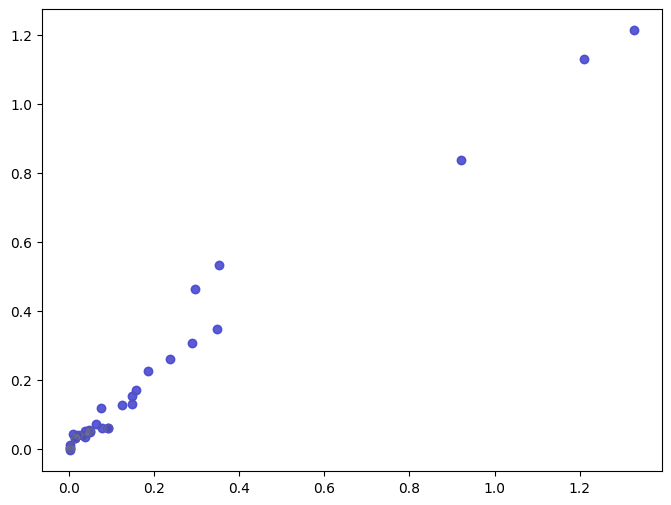

In [24]:
# --- Feature Selection & Scaling ---
features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']

scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Base Model + Grid Search ---
catboost = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000]
}

grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# --- Main Model (Median Prediction) ---
best_model = CatBoostRegressor(**best_params, verbose=0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# --- Quantile Models for Prediction Intervals ---
lower_model = CatBoostRegressor(loss_function='Quantile:alpha=0.1', **best_params, verbose=0)
upper_model = CatBoostRegressor(loss_function='Quantile:alpha=0.9', **best_params, verbose=0)

lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Plot Actual vs Predicted with Prediction Interval ---
y_err_lower = np.abs(y_pred - y_lower)
y_err_upper = np.abs(y_upper - y_pred)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.errorbar(y_test, y_pred, yerr=[y_pred - y_lower, y_upper - y_pred], fmt='o', alpha=0.3, color='gray', label='Prediction Interval')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('CatBoost Regression: Actual vs Predicted with Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

Best Parameters: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.05}
RMSE: 0.0546
MAE: 0.0316
R² Score: 0.9719


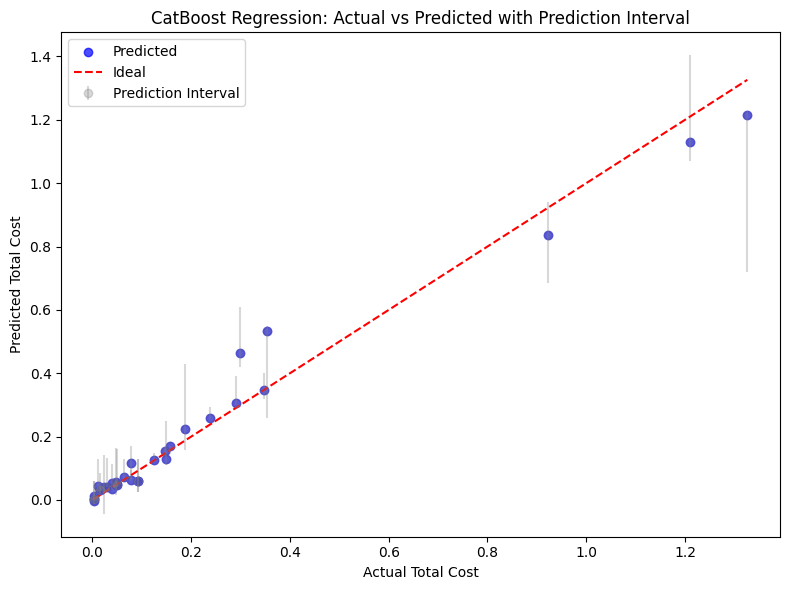

In [ ]:
features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']

scaler = RobustScaler()  # Changed scaler
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Base Model + Grid Search ---
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

catboost = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000]
}

grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# --- Main Model (Median Prediction) ---
best_model = CatBoostRegressor(**best_params, verbose=0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# --- Quantile Models for Prediction Intervals ---
lower_model = CatBoostRegressor(loss_function='Quantile:alpha=0.1', **best_params, verbose=0)
upper_model = CatBoostRegressor(loss_function='Quantile:alpha=0.9', **best_params, verbose=0)

lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Plot Actual vs Predicted with Prediction Interval ---
import matplotlib.pyplot as plt

y_err_lower = np.abs(y_pred - y_lower)
y_err_upper = np.abs(y_upper - y_pred)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.errorbar(y_test, y_pred, yerr=[y_err_lower, y_err_upper], fmt='o', alpha=0.3, color='gray', label='Prediction Interval')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('CatBoost Regression: Actual vs Predicted with Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

### Hyperparameter optimization

[I 2025-04-12 22:49:33,186] A new study created in memory with name: no-name-904dc399-dfa0-45cd-a3b3-ba4754d11abb


[I 2025-04-12 22:49:38,190] Trial 0 finished with value: 0.9579686127073357 and parameters: {'depth': 4, 'learning_rate': 0.0736202646491138, 'iterations': 1683, 'l2_leaf_reg': 6.966334908027121, 'subsample': 0.8917164147425372, 'grow_policy': 'Depthwise', 'random_strength': 0.3951415243982007, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9579686127073357.
[I 2025-04-12 22:49:42,155] Trial 1 finished with value: 0.9107343410603832 and parameters: {'depth': 5, 'learning_rate': 0.004501965261875796, 'iterations': 1440, 'l2_leaf_reg': 6.208889357217097, 'subsample': 0.8624171183270027, 'grow_policy': 'Depthwise', 'random_strength': 0.2806195349268835, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.9579686127073357.
[I 2025-04-12 22:49:47,203] Trial 2 finished with value: 0.9588306852042644 and parameters: {'depth': 4, 'learning_rate': 0.10807405353866062, 'iterations': 1127, 'l2_leaf_reg': 6.818618396401293, 'subsample': 0.7668382704756646, 'grow_policy': 'Depthwise', 'ra

Best parameters from Optuna: {'depth': 5, 'learning_rate': 0.06972622536352201, 'iterations': 1895, 'l2_leaf_reg': 7.26266839645222, 'subsample': 0.818987821228679, 'grow_policy': 'Depthwise', 'random_strength': 0.5794861169923268, 'min_data_in_leaf': 2}

Final Model Performance:
RMSE: 0.0710
MAE: 0.0425
R² Score: 0.9525

Prediction Interval Coverage: 28.12%
Lower Quantile Loss (0.1): 0.0308
Upper Quantile Loss (0.9): 0.0125


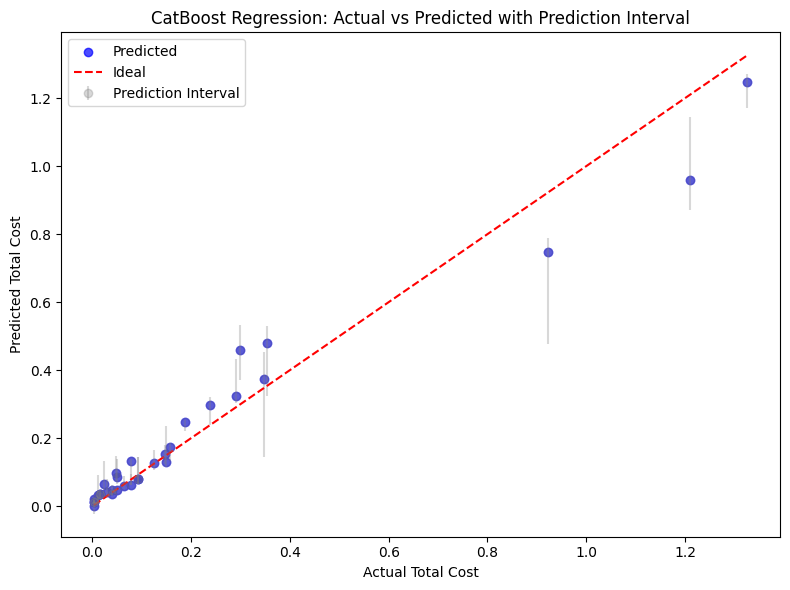

In [ ]:
# --- Feature Selection & Scaling ---
from sklearn.preprocessing import RobustScaler

features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/ '
                     ''
                     'Part)']

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Bayesian Optimization with Optuna ---
import optuna
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20)
    }
    
    model = CatBoostRegressor(**params, verbose=0)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best parameters from Optuna: {best_params}")

# --- Train Final Model with Early Stopping ---
final_model = CatBoostRegressor(
    **best_params,
    early_stopping_rounds=50,
    verbose=0
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

# --- Quantile Models with Optimized Parameters ---
# Reuse best_params but override loss functions
quantile_params = best_params.copy()
quantile_params.pop('loss_function', None)  # Safe removal of key if exists

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.1',
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.9',
    verbose=0
)

lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# --- Predictions & Evaluation ---
y_pred = final_model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Prediction Interval Evaluation ---
def pinball_loss(y_true, y_quantile, alpha):
    return np.mean(np.maximum(alpha*(y_true - y_quantile), (1-alpha)*(y_quantile - y_true)))

interval_coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
print(f"\nPrediction Interval Coverage: {interval_coverage:.2%}")
print(f"Lower Quantile Loss (0.1): {pinball_loss(y_test, y_lower, 0.1):.4f}")
print(f"Upper Quantile Loss (0.9): {pinball_loss(y_test, y_upper, 0.9):.4f}")

# --- Plot Actual vs Predicted with Prediction Interval ---
y_err_lower = np.abs(y_pred - y_lower)
y_err_upper = np.abs(y_upper - y_pred)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.errorbar(y_test, y_pred, yerr=[y_err_lower, y_err_upper], fmt='o', alpha=0.3, color='gray', label='Prediction Interval')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('CatBoost Regression: Actual vs Predicted with Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

### Overfitting

Best Parameters: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.05}

Test Performance:
RMSE: 0.0546
MAE: 0.0316
R² Score: 0.9719

Training Performance:
Train RMSE: 0.0047
Train MAE: 0.0036
Train R²: 1.0000

Performance Gaps (Train - Test):
RMSE difference: -0.0499
MAE difference: -0.0281
R² difference: 0.0280

Generating learning curve...


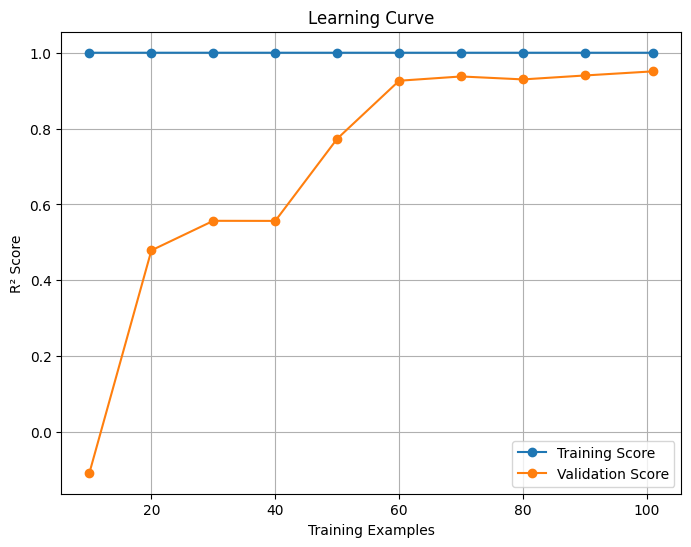


Cross-Validation Results:
                                              params  mean_test_score  \
7  {'depth': 4, 'iterations': 1000, 'learning_rat...         0.938937   
4  {'depth': 4, 'iterations': 500, 'learning_rate...         0.938832   
8  {'depth': 4, 'iterations': 1000, 'learning_rat...         0.927763   
5  {'depth': 4, 'iterations': 500, 'learning_rate...         0.927753   
2  {'depth': 4, 'iterations': 200, 'learning_rate...         0.927003   

   std_test_score  
7        0.018510  
4        0.019571  
8        0.018641  
5        0.018745  
2        0.020915  

Best model CV consistency:
Mean R²: 0.9389
Std R²: 0.0185


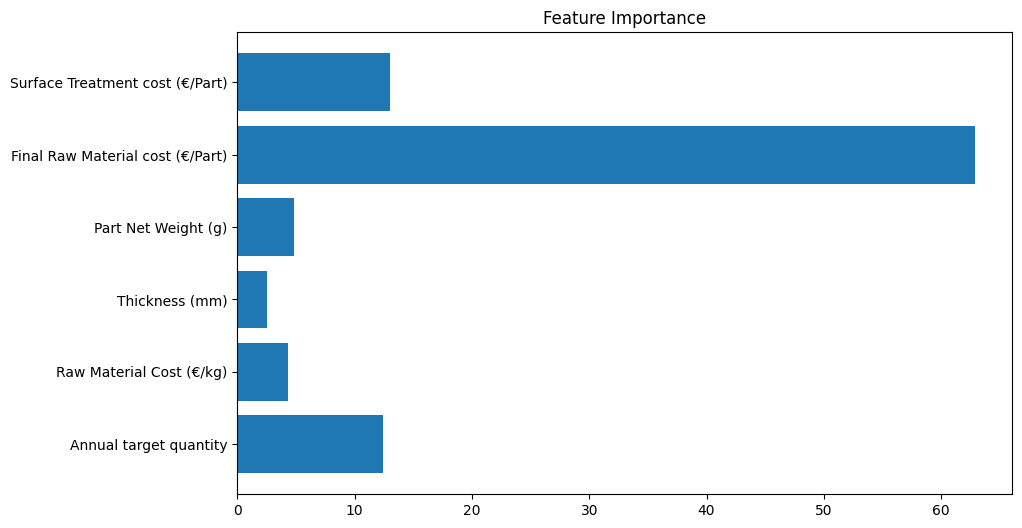


Prediction Interval Analysis:
Average width: 0.0533
Coverage: 18.75%


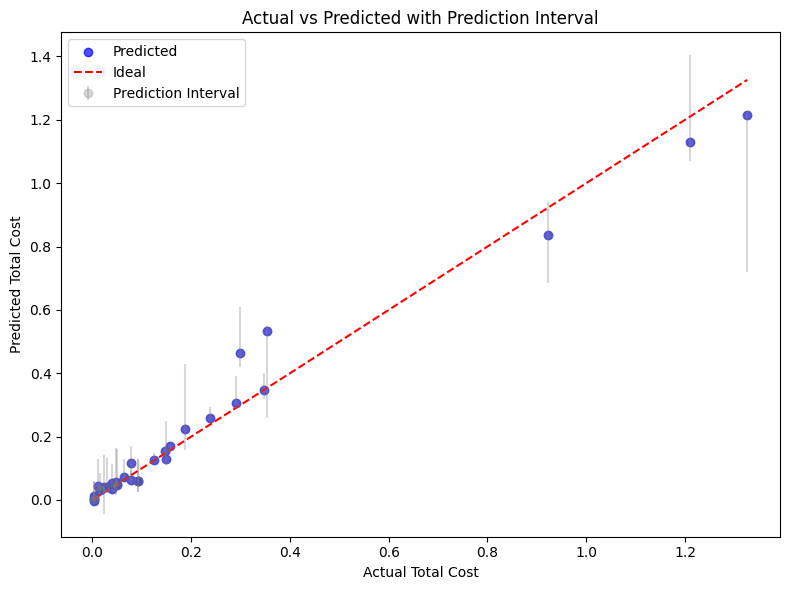

In [15]:
# --- Feature Selection & Scaling ---
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Base Model + Grid Search ---
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

catboost = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000]
}

grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# --- Main Model (Median Prediction) ---
best_model = CatBoostRegressor(**best_params, verbose=0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# --- Quantile Models for Prediction Intervals ---
lower_model = CatBoostRegressor(loss_function='Quantile:alpha=0.1', **best_params, verbose=0)
upper_model = CatBoostRegressor(loss_function='Quantile:alpha=0.9', **best_params, verbose=0)

lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ======================================================================
# 1. Train vs Test Performance Comparison
# ======================================================================
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")

print("\nPerformance Gaps (Train - Test):")
print(f"RMSE difference: {train_rmse - rmse:.4f}")
print(f"MAE difference: {train_mae - mae:.4f}")
print(f"R² difference: {train_r2 - r2:.4f}")

# ======================================================================
# 2. Learning Curve
# ======================================================================
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve():
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=CatBoostRegressor(**best_params, verbose=0),
        X=X_train,
        y=y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation Score')
    plt.xlabel('Training Examples')
    plt.ylabel('R² Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

print("\nGenerating learning curve...")
plot_learning_curve()

# ======================================================================
# 3. Cross-Validation Consistency
# ======================================================================
print("\nCross-Validation Results:")
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)
print(cv_results_sorted.head())

print(f"\nBest model CV consistency:")
print(f"Mean R²: {cv_results_sorted.iloc[0]['mean_test_score']:.4f}")
print(f"Std R²: {cv_results_sorted.iloc[0]['std_test_score']:.4f}")

# ======================================================================
# Additional Diagnostics
# ======================================================================
# Feature Importance
feature_importance = best_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(features_to_scale, feature_importance)
plt.title('Feature Importance')
plt.show()

# Prediction Intervals
interval_widths = y_upper - y_lower
print(f"\nPrediction Interval Analysis:")
print(f"Average width: {np.mean(interval_widths):.4f}")
print(f"Coverage: {np.mean((y_test >= y_lower) & (y_test <= y_upper)):.2%}")

# --- Plot Actual vs Predicted with Prediction Interval ---
y_err_lower = np.abs(y_pred - y_lower)
y_err_upper = np.abs(y_upper - y_pred)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.errorbar(y_test, y_pred, yerr=[y_err_lower, y_err_upper], fmt='o', alpha=0.3, color='gray', label='Prediction Interval')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('Actual vs Predicted with Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

Best Parameters: {'depth': 6, 'grow_policy': 'Depthwise', 'iterations': 1500, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'min_data_in_leaf': 2, 'random_strength': 0.5, 'subsample': 0.9}

Test Performance:
RMSE: 0.0792
MAE: 0.0436
R² Score: 0.9409

Training Performance:
Train RMSE: 0.0004
Train MAE: 0.0003
Train R²: 1.0000

Performance Gaps (Train - Test):
RMSE difference: -0.0788
MAE difference: -0.0432
R² difference: 0.0591

Generating learning curve...


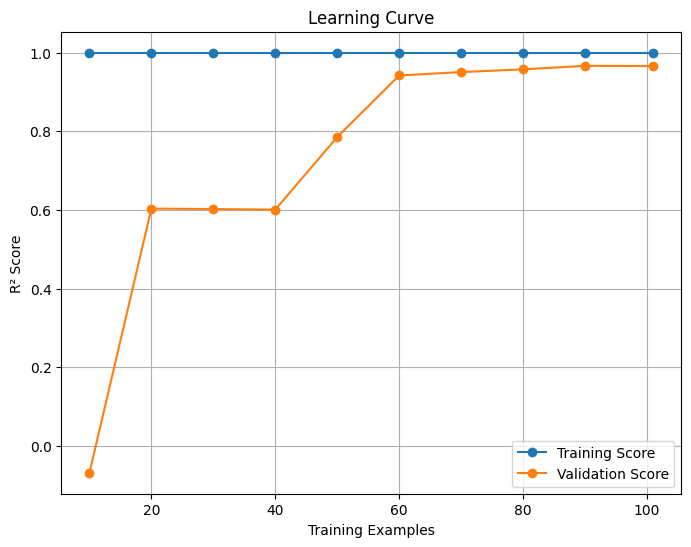


Cross-Validation Results:
                                                params  mean_test_score  \
434  {'depth': 6, 'grow_policy': 'Depthwise', 'iter...         0.969876   
542  {'depth': 6, 'grow_policy': 'Depthwise', 'iter...         0.969871   
613  {'depth': 6, 'grow_policy': 'Depthwise', 'iter...         0.969436   
505  {'depth': 6, 'grow_policy': 'Depthwise', 'iter...         0.969430   
267  {'depth': 5, 'grow_policy': 'Depthwise', 'iter...         0.969258   

     std_test_score  
434        0.012466  
542        0.012458  
613        0.016195  
505        0.016262  
267        0.014485  

Best model CV consistency:
Mean R²: 0.9699
Std R²: 0.0125


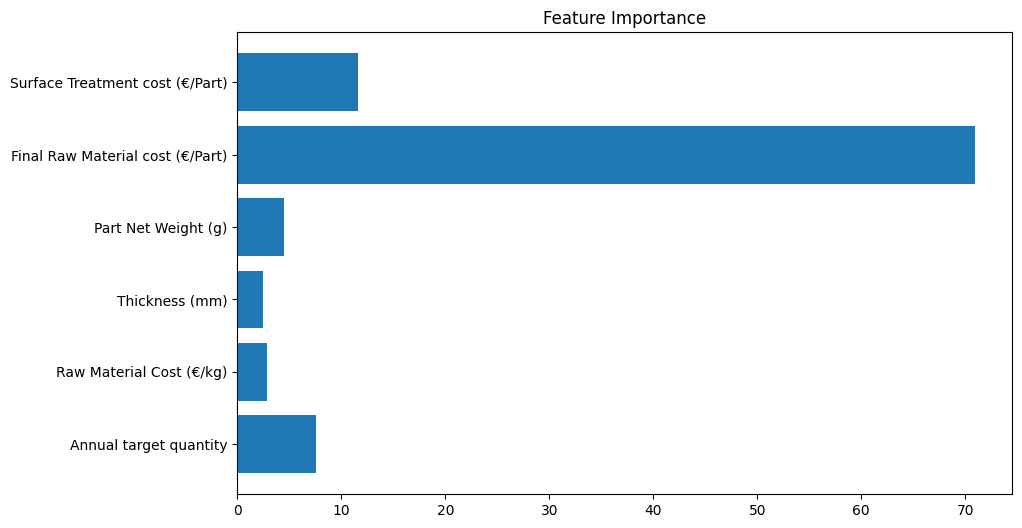


Prediction Interval Analysis:
Average width: -0.0155
Coverage: 15.62%


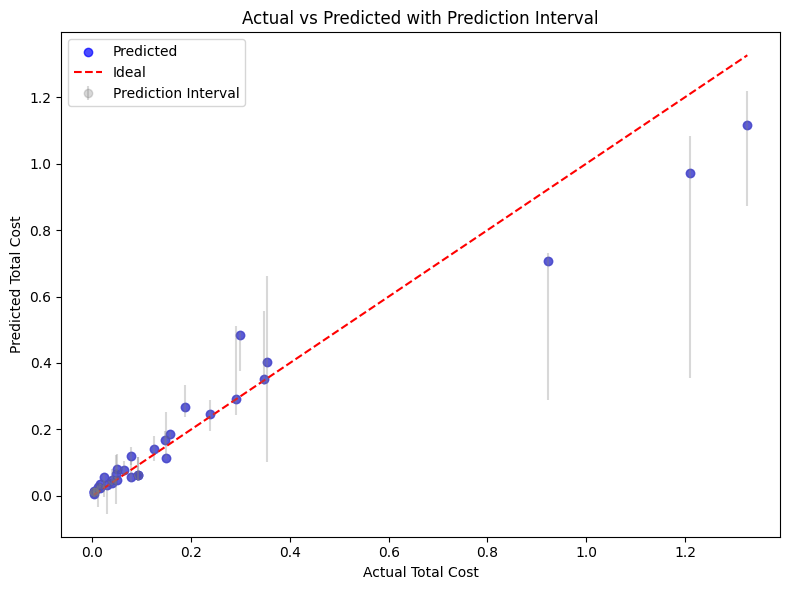

In [17]:
# --- Feature Selection & Scaling ---
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Base Model + Grid Search ---
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

catboost = CatBoostRegressor(verbose=0)
param_grid = {
    'depth': [4, 5, 6],  # Focus around Optuna's 5
    'learning_rate': [0.05, 0.07, 0.1],  # Around Optuna's 0.0697
    'iterations': [1500, 2000],  # Near Optuna's 1895
    'l2_leaf_reg': [5, 7, 9],  # Around Optuna's 7.26
    'subsample': [0.7, 0.8, 0.9],  # Around Optuna's 0.819
    'grow_policy': ['Depthwise'],  # Fixed to Optuna's best
    'random_strength': [0.5, 0.6],  # Around Optuna's 0.579
    'min_data_in_leaf': [2, 5]  # Optuna's was 2
}

grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# --- Main Model (Median Prediction) ---
best_model = CatBoostRegressor(**best_params, verbose=0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# --- Quantile Models for Prediction Intervals ---
lower_model = CatBoostRegressor(loss_function='Quantile:alpha=0.1', **best_params, verbose=0)
upper_model = CatBoostRegressor(loss_function='Quantile:alpha=0.9', **best_params, verbose=0)

lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# ======================================================================
# 1. Train vs Test Performance Comparison
# ======================================================================
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")

print("\nPerformance Gaps (Train - Test):")
print(f"RMSE difference: {train_rmse - rmse:.4f}")
print(f"MAE difference: {train_mae - mae:.4f}")
print(f"R² difference: {train_r2 - r2:.4f}")

# ======================================================================
# 2. Learning Curve
# ======================================================================
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve():
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=CatBoostRegressor(**best_params, verbose=0),
        X=X_train,
        y=y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation Score')
    plt.xlabel('Training Examples')
    plt.ylabel('R² Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

print("\nGenerating learning curve...")
plot_learning_curve()

# ======================================================================
# 3. Cross-Validation Consistency
# ======================================================================
print("\nCross-Validation Results:")
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)
print(cv_results_sorted.head())

print(f"\nBest model CV consistency:")
print(f"Mean R²: {cv_results_sorted.iloc[0]['mean_test_score']:.4f}")
print(f"Std R²: {cv_results_sorted.iloc[0]['std_test_score']:.4f}")

# ======================================================================
# Additional Diagnostics
# ======================================================================
# Feature Importance
feature_importance = best_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(features_to_scale, feature_importance)
plt.title('Feature Importance')
plt.show()

# Prediction Intervals
interval_widths = y_upper - y_lower
print(f"\nPrediction Interval Analysis:")
print(f"Average width: {np.mean(interval_widths):.4f}")
print(f"Coverage: {np.mean((y_test >= y_lower) & (y_test <= y_upper)):.2%}")

# --- Plot Actual vs Predicted with Prediction Interval ---
y_err_lower = np.abs(y_pred - y_lower)
y_err_upper = np.abs(y_upper - y_pred)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.errorbar(y_test, y_pred, yerr=[y_err_lower, y_err_upper], fmt='o', alpha=0.3, color='gray', label='Prediction Interval')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('Actual vs Predicted with Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()

Starting faster hyperparameter search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Best Parameters: {'depth': 4, 'grow_policy': 'Depthwise', 'iterations': 1000, 'l2_leaf_reg': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 5, 'subsample': 0.7}

Training quantile models...

Test Performance:
RMSE: 0.0611
MAE: 0.0463
R² Score: 0.9648

Train R²: 0.9876 vs Test R²: 0.9648
R² Gap: 0.0227 (OK)

Prediction Intervals:
Average width: 0.0642
Coverage: 31.25% (Target: 60-80%)


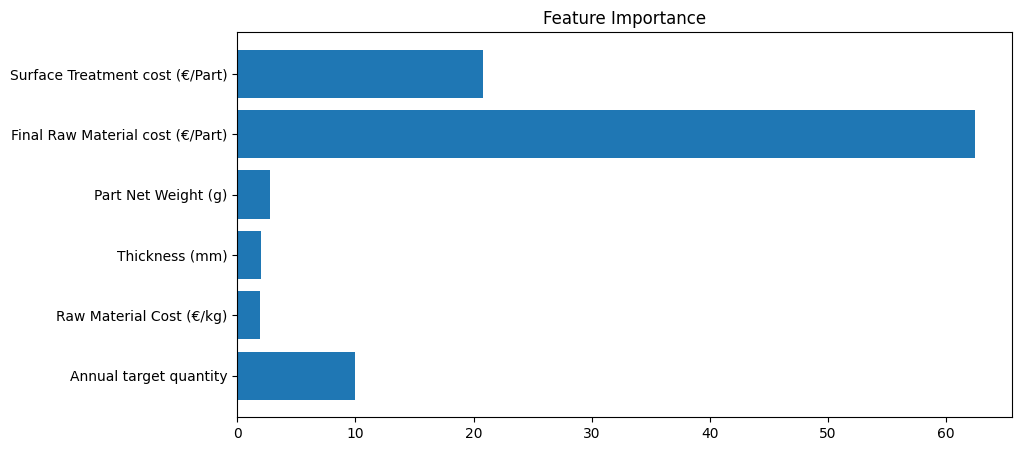

In [19]:
# --- Feature Selection & Scaling ---
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

features_to_scale = ['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 
                     'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)']

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Faster Hyperparameter Search ---
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Reduced parameter grid
param_grid = {
    'depth': [4, 5],  # Only test these depths
    'learning_rate': [0.05, 0.07],  # Focused range
    'iterations': [800, 1000],  # Fewer iterations
    'l2_leaf_reg': [7, 10],  # Stronger regularization
    'subsample': [0.7, 0.8],  # Feature subsampling
    'grow_policy': ['Depthwise'],  # Fixed
    'min_data_in_leaf': [3, 5]  # Prevent overfitting
}

# Faster grid search with 3-fold CV
grid_search = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0),
    param_grid=param_grid,
    cv=3,  # Reduced from 5
    scoring='r2',
    n_jobs=-1,
    verbose=2  # Show progress
)

print("Starting faster hyperparameter search...")
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest Parameters: {best_params}")

# --- Train Final Model with Early Stopping ---

final_model = CatBoostRegressor(
    **best_params,
    early_stopping_rounds=20,  # Use ONLY this (remove od_wait)
    od_type='IncToDec',  # Keep this overfitting detector type
    verbose=0
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)
# --- Simplified Quantile Models ---
quantile_params = {
    k: v for k, v in best_params.items() 
    if k not in ['loss_function', 'iterations']
}

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.2',  # Wider interval
    iterations=500,  # Fewer iterations for quantiles
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.8',
    iterations=500,
    verbose=0
)

print("\nTraining quantile models...")
lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# --- Evaluation ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Train vs Test Comparison ---
y_train_pred = final_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f"\nTrain R²: {train_r2:.4f} vs Test R²: {r2:.4f}")
print(f"R² Gap: {train_r2 - r2:.4f} ({'OK' if (train_r2 - r2) < 0.05 else 'Overfitting!'})")

# --- Prediction Interval Analysis ---
interval_widths = y_upper - y_lower
coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
print(f"\nPrediction Intervals:")
print(f"Average width: {np.mean(interval_widths):.4f}")
print(f"Coverage: {coverage:.2%} (Target: 60-80%)")

# --- Feature Importance ---
feature_importance = final_model.get_feature_importance()
plt.figure(figsize=(10,5))
plt.barh(features_to_scale, feature_importance)
plt.title('Feature Importance')
plt.show()

Training final model...

Training quantile models...

Test Performance:
RMSE: 0.0602
MAE: 0.0458
R² Score: 0.9658

Train R²: 0.9841 vs Test R²: 0.9658
R² Gap: 0.0183 (OK)

Improved Prediction Intervals:
Average width: 0.1057
Coverage: 40.62% (Target: 60-80%)


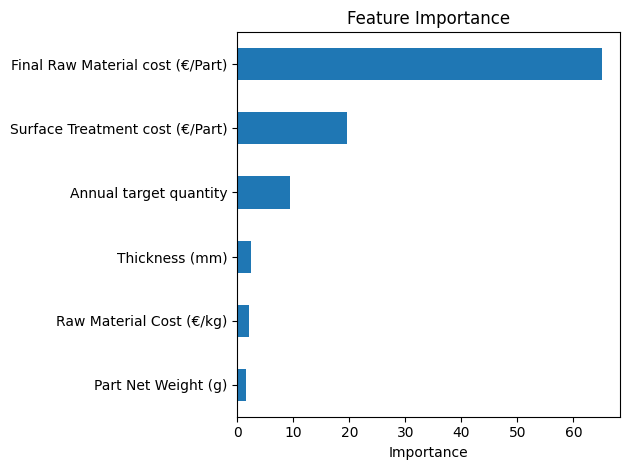

In [20]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Scaling ---
features_to_scale = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)'
]

scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Feature/Target Split ---
X = df[features_to_scale]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Final Model with Stronger Regularization ---
final_model = CatBoostRegressor(
    depth=4,
    iterations=800,
    learning_rate=0.05,
    l2_leaf_reg=15,
    subsample=0.6,
    grow_policy='Depthwise',
    min_data_in_leaf=5,
    early_stopping_rounds=20,
    od_type='IncToDec',
    verbose=0
)

# --- Improved Quantile Models ---
quantile_params = {
    'depth': 3,
    'iterations': 400,
    'learning_rate': 0.03,
    'l2_leaf_reg': 20,
    'subsample': 0.5,
    'min_data_in_leaf': 10
}

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.15',
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.85',
    verbose=0
)

# --- Training ---
print("Training final model...")
final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

print("\nTraining quantile models...")
lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = final_model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Train vs Test Comparison ---
y_train_pred = final_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f"\nTrain R²: {train_r2:.4f} vs Test R²: {r2:.4f}")
print(f"R² Gap: {train_r2 - r2:.4f} ({'OK' if (train_r2 - r2) < 0.05 else 'Overfitting!'})")

# --- Prediction Interval Analysis ---
interval_widths = y_upper - y_lower
coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
print(f"\nImproved Prediction Intervals:")
print(f"Average width: {np.mean(interval_widths):.4f}")
print(f"Coverage: {coverage:.2%} (Target: 60-80%)")

# --- Feature Importance Visualization ---
feature_importance = final_model.get_feature_importance()
pd.Series(feature_importance, index=features_to_scale).sort_values().plot.barh()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


Training final model...

Training quantile models...

Test Performance:
RMSE: 0.0561
MAE: 0.0407
R² Score: 0.9704

Train R²: 0.9878 vs Test R²: 0.9704
R² Gap: 0.0174 (OK)

Improved Prediction Intervals:
Average width: 0.1080
Coverage: 53.12% (Target: 60-80%)


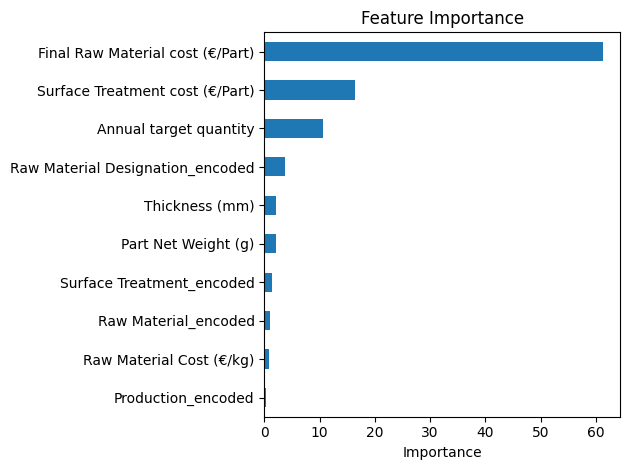

In [21]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

encoded_features = [
    'Production_encoded',
    'Raw Material_encoded',
    'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# --- Scaling Only Numerical Features ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# --- Combine All Features for Modeling ---
selected_features = features_to_scale + encoded_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Final Model with Stronger Regularization ---
final_model = CatBoostRegressor(
    depth=4,
    iterations=800,
    learning_rate=0.05,
    l2_leaf_reg=15,
    subsample=0.6,
    grow_policy='Depthwise',
    min_data_in_leaf=5,
    early_stopping_rounds=20,
    od_type='IncToDec',
    verbose=0
)

# --- Improved Quantile Models ---
quantile_params = {
    'depth': 3,
    'iterations': 400,
    'learning_rate': 0.03,
    'l2_leaf_reg': 20,
    'subsample': 0.5,
    'min_data_in_leaf': 10
}

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.15',
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.85',
    verbose=0
)

# --- Training Final Model ---
print("Training final model...")
final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

# --- Training Quantile Models ---
print("\nTraining quantile models...")
lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = final_model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Train vs Test R² Comparison ---
y_train_pred = final_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f"\nTrain R²: {train_r2:.4f} vs Test R²: {r2:.4f}")
print(f"R² Gap: {train_r2 - r2:.4f} ({'OK' if (train_r2 - r2) < 0.05 else 'Overfitting!'})")

# --- Prediction Interval Analysis ---
interval_widths = y_upper - y_lower
coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
print(f"\nImproved Prediction Intervals:")
print(f"Average width: {np.mean(interval_widths):.4f}")
print(f"Coverage: {coverage:.2%} (Target: 60-80%)")

# --- Feature Importance Visualization ---
feature_importance = final_model.get_feature_importance()
pd.Series(feature_importance, index=selected_features).sort_values().plot.barh()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



=== Performance Metrics ===
Test RMSE: 0.0561 | MAE: 0.0407 | R²: 0.9704
Train R²: 0.9878 | R² Gap: 0.0174

=== Overfitting Analysis ===
1. Learning Curve:


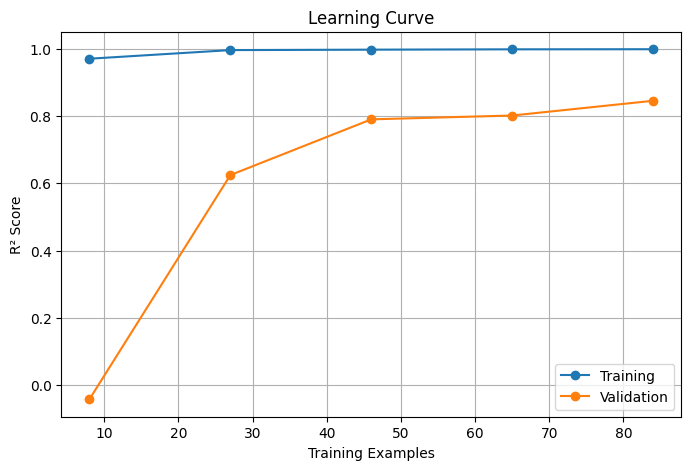


2. Feature Importance:


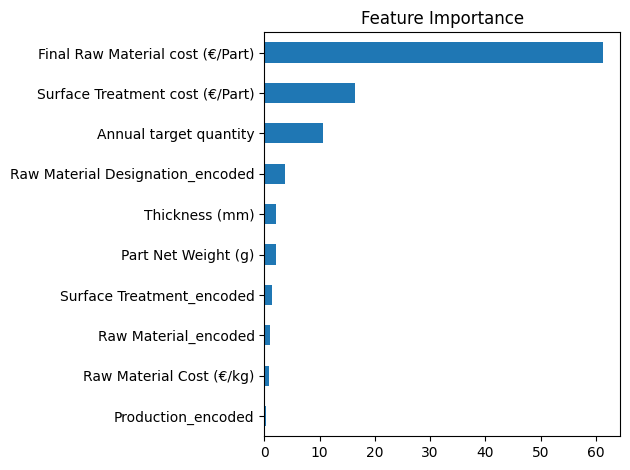


=== Prediction Visualization ===


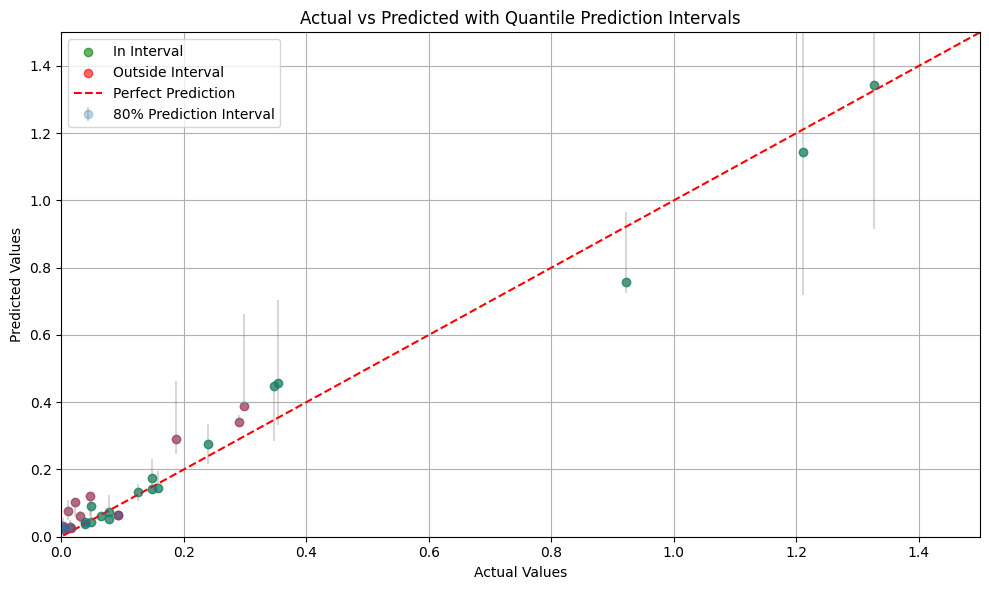


Prediction Interval Coverage: 53.12% (Target: 60–80%)
Out-of-Interval Predictions: 15 out of 32
Average Interval Width: 0.1080


In [27]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

encoded_features = [
    'Production_encoded',
    'Raw Material_encoded',
    'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# --- Data Preparation ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
selected_features = features_to_scale + encoded_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Training ---
final_model = CatBoostRegressor(
    depth=4, iterations=800, learning_rate=0.05,
    l2_leaf_reg=15, subsample=0.6, grow_policy='Depthwise',
    min_data_in_leaf=5, early_stopping_rounds=20,
    od_type='IncToDec', verbose=0
)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# --- Quantile Models ---
quantile_params = {
    'depth': 3, 'iterations': 400, 'learning_rate': 0.03,
    'l2_leaf_reg': 20, 'subsample': 0.5, 'min_data_in_leaf': 10
}
lower_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.15', verbose=0)
upper_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.85', verbose=0)
lower_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = final_model.predict(X_test)
y_lower = lower_model.predict(X_test)
y_upper = upper_model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
y_train_pred = final_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("\n=== Performance Metrics ===")
print(f"Test RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
print(f"Train R²: {train_r2:.4f} | R² Gap: {train_r2 - r2:.4f}")

# --- Overfitting Diagnostics ---
print("\n=== Overfitting Analysis ===")
print("1. Learning Curve:")
def plot_learning_curve():
    train_sizes, train_scores, val_scores = learning_curve(
        final_model, X_train, y_train, cv=3, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, 1), 'o-', label='Validation')
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()
plot_learning_curve()

print("\n2. Feature Importance:")
feature_importance = final_model.get_feature_importance()
pd.Series(feature_importance, index=selected_features).sort_values().plot.barh()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# --- Prediction Plot ---
print("\n=== Prediction Visualization ===")
plt.figure(figsize=(10, 6))

# Markers for in-bound and out-of-bound
within_bounds = (y_test >= y_lower) & (y_test <= y_upper)
outside_bounds = ~within_bounds

# Scatter plot with color-coded intervals
plt.scatter(y_test[within_bounds], y_pred[within_bounds], color='green', alpha=0.6, label='In Interval')
plt.scatter(y_test[outside_bounds], y_pred[outside_bounds], color='red', alpha=0.6, label='Outside Interval')

# Error bars (always positive)
plt.errorbar(
    y_test, y_pred, 
    yerr=[np.abs(y_pred - y_lower), np.abs(y_upper - y_pred)],
    fmt='o', ecolor='gray', alpha=0.3, label='80% Prediction Interval'
)

# Perfect prediction line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted with Quantile Prediction Intervals")
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Prediction Interval Stats ---
coverage = np.mean(within_bounds)
outside_count = outside_bounds.sum()
print(f"\nPrediction Interval Coverage: {coverage:.2%} (Target: 60–80%)")
print(f"Out-of-Interval Predictions: {outside_count} out of {len(y_test)}")
print(f"Average Interval Width: {np.mean(y_upper - y_lower):.4f}")


Cross-Validation Mean Score (Negative MSE): 0.1504
Cross-Validation Standard Deviation (Negative MSE): 0.2376

=== Performance Metrics ===
RMSE: 0.0369 | MAE: 0.0205 | R²: 0.9971

=== Overfitting Analysis ===
1. Learning Curve:


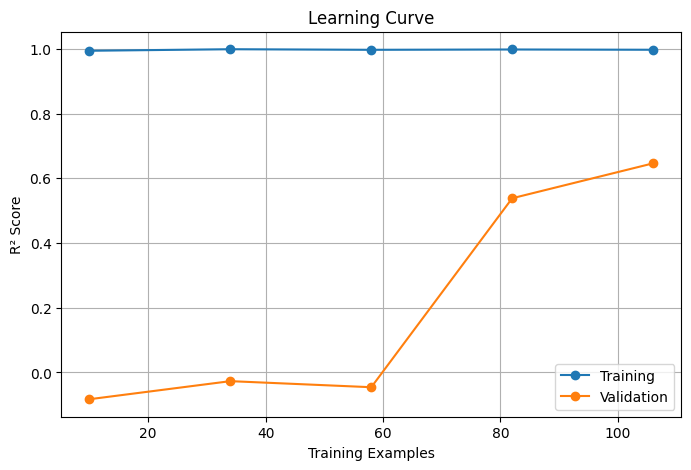


2. Feature Importance:


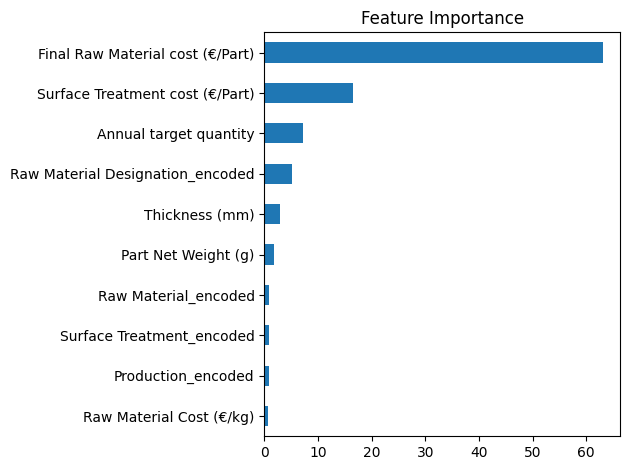


=== Prediction Visualization ===


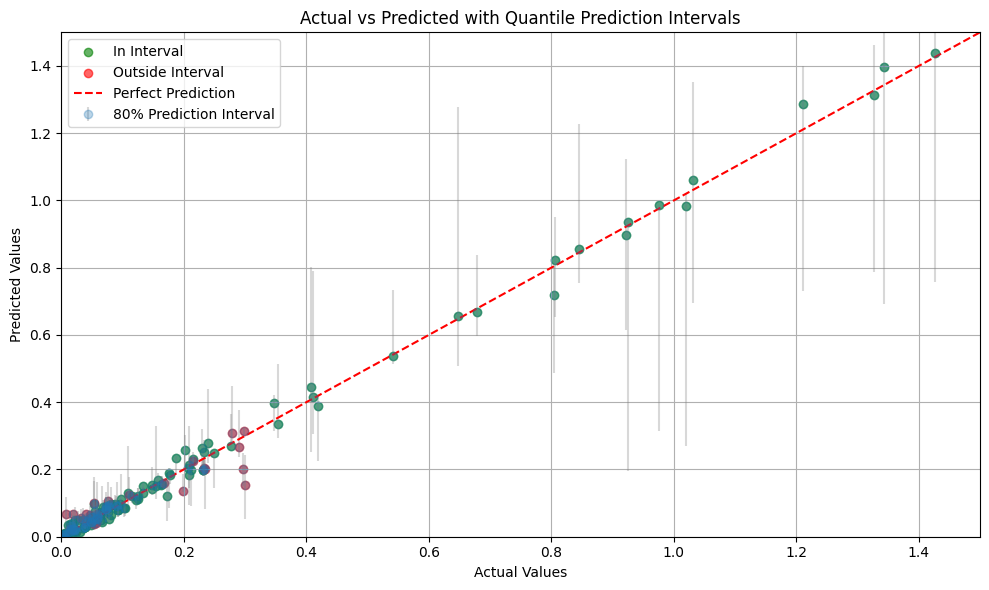


Prediction Interval Coverage: 82.39% (Target: 60–80%)
Out-of-Interval Predictions: 28 out of 159
Average Interval Width: 0.1878


In [28]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

encoded_features = [
    'Production_encoded',
    'Raw Material_encoded',
    'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# --- Data Preparation ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
selected_features = features_to_scale + encoded_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

# --- Model Training ---
final_model = CatBoostRegressor(
    depth=4, iterations=800, learning_rate=0.05,
    l2_leaf_reg=15, subsample=0.6, grow_policy='Depthwise',
    min_data_in_leaf=5, early_stopping_rounds=20,
    od_type='IncToDec', verbose=0
)

# --- Cross-Validation ---
cv_results = cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# --- Print Cross-Validation Results ---
print(f"Cross-Validation Mean Score (Negative MSE): {-cv_results.mean():.4f}")
print(f"Cross-Validation Standard Deviation (Negative MSE): {cv_results.std():.4f}")

# --- Quantile Models ---
quantile_params = {
    'depth': 3, 'iterations': 400, 'learning_rate': 0.03,
    'l2_leaf_reg': 20, 'subsample': 0.5, 'min_data_in_leaf': 10
}
lower_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.15', verbose=0)
upper_model = CatBoostRegressor(**quantile_params, loss_function='Quantile:alpha=0.85', verbose=0)

# --- Fit Quantile Models with Full Dataset ---
lower_model.fit(X, y)
upper_model.fit(X, y)

# --- Predictions ---
y_pred = final_model.fit(X, y).predict(X)  # Fit model on entire dataset for predictions
y_lower = lower_model.predict(X)
y_upper = upper_model.predict(X)

# --- Evaluation (using predictions on entire dataset due to cross-validation) ---
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("\n=== Performance Metrics ===")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

# --- Overfitting Diagnostics ---
print("\n=== Overfitting Analysis ===")
print("1. Learning Curve:")
def plot_learning_curve():
    train_sizes, train_scores, val_scores = learning_curve(
        final_model, X, y, cv=3, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, 1), 'o-', label='Validation')
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()
plot_learning_curve()

print("\n2. Feature Importance:")
feature_importance = final_model.get_feature_importance()
pd.Series(feature_importance, index=selected_features).sort_values().plot.barh()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# --- Prediction Plot ---
print("\n=== Prediction Visualization ===")
plt.figure(figsize=(10, 6))

# Markers for in-bound and out-of-bound
within_bounds = (y >= y_lower) & (y <= y_upper)
outside_bounds = ~within_bounds

# Scatter plot with color-coded intervals
plt.scatter(y[within_bounds], y_pred[within_bounds], color='green', alpha=0.6, label='In Interval')
plt.scatter(y[outside_bounds], y_pred[outside_bounds], color='red', alpha=0.6, label='Outside Interval')

# Error bars (always positive)
plt.errorbar(
    y, y_pred, 
    yerr=[np.abs(y_pred - y_lower), np.abs(y_upper - y_pred)],
    fmt='o', ecolor='gray', alpha=0.3, label='80% Prediction Interval'
)

# Perfect prediction line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted with Quantile Prediction Intervals")
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- Prediction Interval Stats ---
coverage = np.mean(within_bounds)
outside_count = outside_bounds.sum()
print(f"\nPrediction Interval Coverage: {coverage:.2%} (Target: 60–80%)")
print(f"Out-of-Interval Predictions: {outside_count} out of {len(y)}")
print(f"Average Interval Width: {np.mean(y_upper - y_lower):.4f}")



=== Cross-Validation Results ===
Mean RMSE: 0.3694
Std RMSE: 0.4755

=== Training Models ===


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Training quantile models...

=== Enhanced Performance Metrics ===
Metric    Value
  RMSE 0.114227
   MAE 0.052211
    R² 0.972149

=== Overfitting Analysis ===
Training R²: 0.9721
Training-Test Gap: 0.0000

Key Features (>5% importance): ['Annual target quantity', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)', 'Raw Material Designation_encoded']


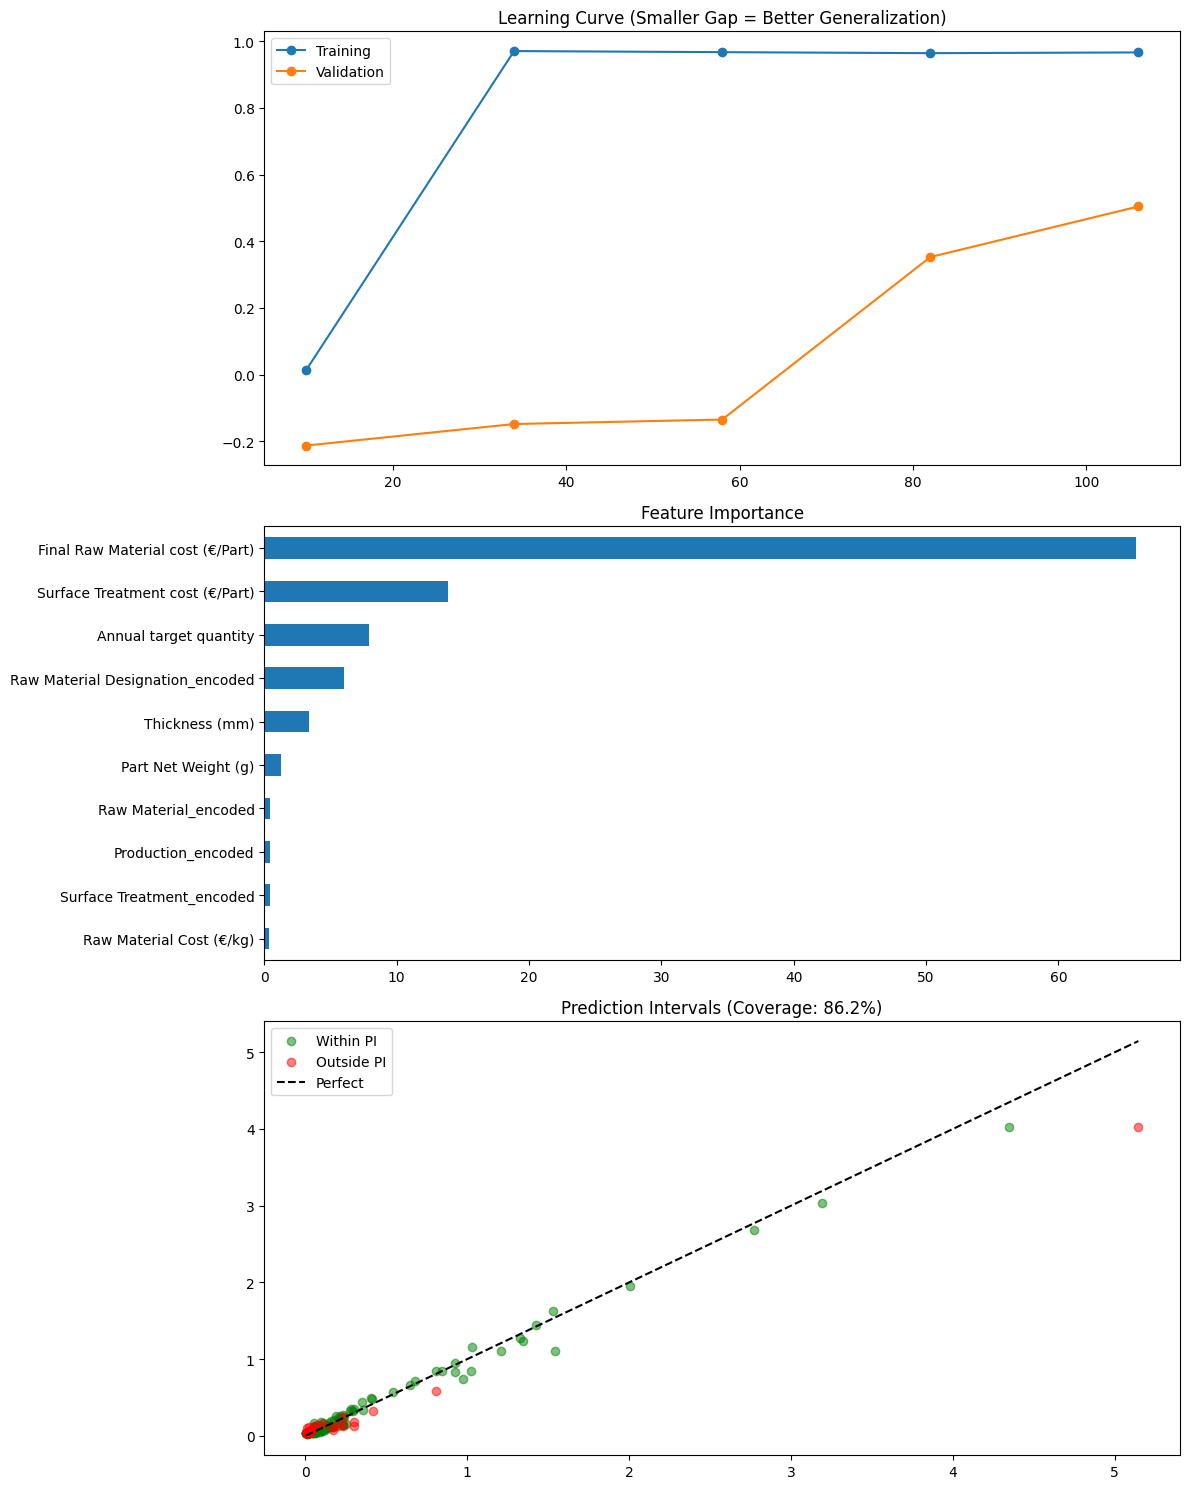


=== Prediction Interval Analysis ===
Coverage: 86.16% (Target: 80%)
Average Width: 0.3465
Width Std Dev: 0.6982


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Final Raw Material cost (€/Part)', 
    'Surface Treatment cost (€/Part)'
]

encoded_features = [
    'Production_encoded',
    'Raw Material_encoded',
    'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# --- Data Preparation ---
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
selected_features = features_to_scale + encoded_features
X = df[selected_features]
y = df['Total cost with amortization (€/part)']

# --- Model Training with Improved Regularization ---
final_model = CatBoostRegressor(
    depth=3,  # Reduced from 4 (shallower trees)
    iterations=600,  # Reduced from 800
    learning_rate=0.03,  # Slower learning
    l2_leaf_reg=20,  # Stronger regularization
    subsample=0.5,  # More feature randomization
    min_data_in_leaf=10,  # Fewer leaves
    grow_policy='Depthwise',
    early_stopping_rounds=20,
    od_type='IncToDec',
    verbose=0
)

# --- Cross-Validation with Error Handling ---
try:
    cv_results = cross_val_score(final_model, X, y, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean RMSE: {np.sqrt(-cv_results.mean()):.4f}")
    print(f"Std RMSE: {np.sqrt(cv_results.std()):.4f}")
except Exception as e:
    print(f"CV Error: {str(e)}")

# --- Quantile Models with Conservative Settings ---
quantile_params = {
    'depth': 2,  # Even simpler than main model
    'iterations': 300,
    'learning_rate': 0.02,
    'l2_leaf_reg': 30,  # Extra regularization
    'subsample': 0.4,
    'min_data_in_leaf': 15,
    'grow_policy': 'Depthwise'
}

lower_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.1',  # Wider interval (80% PI)
    verbose=0
)

upper_model = CatBoostRegressor(
    **quantile_params,
    loss_function='Quantile:alpha=0.9',
    verbose=0
)

# --- Training with Progress Monitoring ---
print("\n=== Training Models ===")
final_model.fit(X, y, plot=True)  # Visual training progress

print("\nTraining quantile models...")
lower_model.fit(X, y)
upper_model.fit(X, y)

# --- Predictions ---
y_pred = final_model.predict(X)
y_lower = lower_model.predict(X)
y_upper = upper_model.predict(X)

# --- Enhanced Evaluation ---
print("\n=== Enhanced Performance Metrics ===")
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²'],
    'Value': [rmse, mae, r2]
})
print(metrics.to_string(index=False))

# --- Advanced Overfitting Diagnostics ---
print("\n=== Overfitting Analysis ===")
train_pred = final_model.predict(X)
train_r2 = r2_score(y, train_pred)
print(f"Training R²: {train_r2:.4f}")
print(f"Training-Test Gap: {train_r2 - r2:.4f}")

# Feature Importance with Threshold
feature_imp = final_model.get_feature_importance()
imp_threshold = 0.05 * sum(feature_imp)  # 5% of total importance
important_features = [f for f, imp in zip(selected_features, feature_imp) if imp > imp_threshold]
print(f"\nKey Features (>5% importance): {important_features}")

# --- Visualizations ---
plt.figure(figsize=(12, 15))

# 1. Learning Curve
plt.subplot(3, 1, 1)
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=3, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)
plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training')
plt.plot(train_sizes, np.mean(val_scores, 1), 'o-', label='Validation')
plt.title("Learning Curve (Smaller Gap = Better Generalization)")
plt.legend()

# 2. Feature Importance
plt.subplot(3, 1, 2)
pd.Series(feature_imp, index=selected_features).sort_values().plot.barh()
plt.title("Feature Importance")

# 3. Prediction Intervals
plt.subplot(3, 1, 3)
within_bounds = (y >= y_lower) & (y <= y_upper)
plt.scatter(y[within_bounds], y_pred[within_bounds], c='green', alpha=0.5, label='Within PI')
plt.scatter(y[~within_bounds], y_pred[~within_bounds], c='red', alpha=0.5, label='Outside PI')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect')
plt.title(f"Prediction Intervals (Coverage: {np.mean(within_bounds):.1%})")
plt.legend()

plt.tight_layout()
plt.show()

# --- Prediction Interval Statistics ---
print("\n=== Prediction Interval Analysis ===")
print(f"Coverage: {np.mean(within_bounds):.2%} (Target: 80%)")
print(f"Average Width: {np.mean(y_upper - y_lower):.4f}")
print(f"Width Std Dev: {np.std(y_upper - y_lower):.4f}")
1
# --- Model Export (Optional) ---
# final_model.save_model('optimized_cost_model.cbm')